In [1]:
import pickle as pkl
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from figrid.data_container import DataContainer

pplib.imports()
COSMO = '/Users/cosinga/overleaf/hi_cosmo/figures/'

In [2]:
ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/12-29_pkdatasort.pkl', 'rb'))
print(ds.getAttrs())

ds.tickArgs(direction = 'in', right = True, top = True, labelsize = 14)
ds.legendArgs(frameon = False, loc = 'upper right', fontsize = 14, slc = (-1, -1))

ds.axisLabelArgs('both', fontsize = 16)
ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 16, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 16, ha = 'center' , va = 'top')
ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.04, 10])

ds.setOrder('space', ['real', 'redshift', 'rsd'])

ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
# ds.displayAs('color', ['blue', 'red', 'resolved'], 
#              ['HI $\\times$ Blue Bias', 'HI $\\times$ Red Bias', 'HI $\\times$ Galaxy Bias'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Particles in Galaxies'])
ds.displayAs('color', ['blue', 'red', 'resolved', 'no key found'], ['Blue Gal.', 'Red Gal.', 'All Gal.', 'HI'])
ds.setColors('HI_fieldname', ['firebrick', 'saddlebrown', 'sandybrown'], ['vn', 'hiptl', 'hisubhalo'])
ds.setColors('color', ['red', 'blue', 'gray'], ['red', 'blue', 'resolved'])

ds.setXLabel(pplib.wnum())
print(ds.getAttrVals('post_process'))
print(ds.getAttrVals('fieldname'))

['path', 'result_type', 'result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'color', 'gal_species', 'gal_res', 'color_cut', 'ptl_species', 'map', 'model', 'HI_fieldname', 'projection', 'HI_res', 'censat', 'type', 'subtype', 'empty_cells', 'post_process', 'numerator', 'denominator']
['no key found', 'theory_bias', 'obs_bias', 'corr_coef']
['galaxy', 'hiptl_ptl', 'hiptl', 'vn_galaxy', 'hiptl_galaxy', 'galaxy_dust', 'vn_ptl', 'vn', 'ptl', 'hisubhalo_ptl', 'hisubhalo_galaxy', 'hisubhalo', 'galaxy_ptl', 'hisubhalo_galaxy_dust']


In [3]:
def calc_obs_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    auto = ds.getMatching(ip)
    biases = []
    for i in range(len(auto)):
        
        data = [auto[i].data[0], np.sqrt(auto[i].data[1] / ptl_auto.data[1])]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(auto[i].attrs))
        dc.add('post_process','obs_bias')
        dc.add('is_auto', False)
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')

        biases.append(dc)
    return biases

def calc_th_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    cross = ds.getMatching(ip)
    biases = []
    for i in range(len(cross)):
        
        data = [cross[i].data[0], cross[i].data[1] / ptl_auto.data[1]]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(cross[i].attrs))
        dc.add('post_process','theory_bias')
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')
        biases.append(dc)
    return biases
def save_bias(biases):
    SAVE_ATTRS = ['simname', 'snapshot', 'space', 'post_process', 'color', 'model']
    bvals = []
    for bias in biases:
        bval = bias.getData()[1][1]
        attrs = [bias.get(attr) for attr in SAVE_ATTRS]
        bvals.append([bval, attrs])
    return bvals
        

In [4]:
simnames = ['tng100', 'tng300']
snapshots = [50, 67, 99]
spaces = ['real', 'redshift']
bvals = []
for name in simnames:
    for snap in snapshots:
        for space in spaces:
            
            print("\n", name, snap, space)
            hiip = {'is_auto':True, "HI_fieldname":['vn', 'hiptl'],      
              'axis':0, 'grid_resolution':800, 'simname': name,
              'mas':'CICW', 'snapshot':snap, 'space':space,
             'path':'fiducial', 'post_process':'no key found'}
            obs_biases = calc_obs_bias(hiip)
            print('hi biases:', len(obs_biases))
            ds.extend(obs_biases)
            bvals.extend(save_bias(obs_biases))
            galip = {'gal_res':'diemer',
                      'gal_species':'stmass', 'sim_resolution':'high', 
                     'axis':0, 'grid_resolution':800,
                      'censat':['no key found', 'both'], 'mas':'CICW', 
                     'color': ['blue', 'red', 'resolved'], 'fieldname':'galaxy',
                     'path':'fiducial', 'simname':name, 'space':space,
                    'snapshot':snap, 'post_process':'no key found'}
            obs_biases = calc_obs_bias(galip)
            print('galaxy biases:', len(obs_biases))
            bvals.extend(save_bias(obs_biases))
            ds.extend(obs_biases)


 tng100 50 real
hi biases: 5
galaxy biases: 3

 tng100 50 redshift
hi biases: 5
galaxy biases: 3

 tng100 67 real
hi biases: 5
galaxy biases: 3

 tng100 67 redshift
hi biases: 5
galaxy biases: 3

 tng100 99 real
hi biases: 5
galaxy biases: 3

 tng100 99 redshift
hi biases: 5
galaxy biases: 3

 tng300 50 real
hi biases: 5
galaxy biases: 3

 tng300 50 redshift
hi biases: 5
galaxy biases: 3

 tng300 67 real
hi biases: 5
galaxy biases: 3

 tng300 67 redshift
hi biases: 5
galaxy biases: 3

 tng300 99 real
hi biases: 5
galaxy biases: 3

 tng300 99 redshift
hi biases: 5
galaxy biases: 3


The row values for : ['no key found']
The column values for snapshot: [99, 67, 50]
The row values for : ['no key found']
The column values for snapshot: [99, 67, 50]
0.7664835743116538
0.7600962577235726
0.7631263291523578
0.7691943621599829
0.7774558094090578
0.9346407176458006
1.6625237212281365
1.4682604650366469
1.0175790199080847
1.0210293657807914
1.022006355511445
1.0258544151799944
1.006335454892207
1.305874537802232
2.101129534099574
1.7110370337720227
1.292068184052896
1.3193217494174345
1.3171328291310556
1.3005691386596485
1.3020203905432035
1.7396967077251075
2.613338613955335
2.044481908581083
(1, 3)


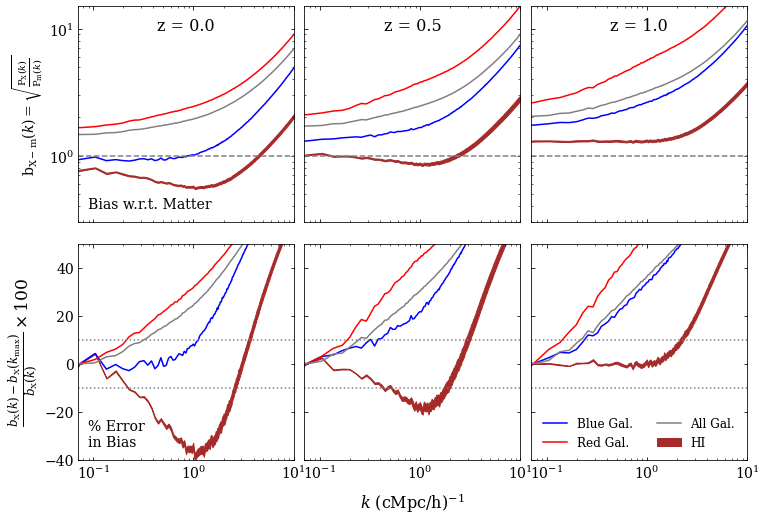

In [28]:
def lin_error(dc):
    data = dc.getData()
    x = data[0]
    y = data[1]
#     lin_est = np.mean(y[1:3])
    lin_est = y[1]
    print(lin_est)
    y = (y - lin_est) / y * 100
    dc.setData([x, y])
    return

ip = {'is_auto':False, 
      'axis':0, 'grid_resolution':800, 'simname': ['tng300'],
      'post_process':['obs_bias'], 'snapshot':[99, 67, 50], 'space':'real',
     'path':'fiducial', 'denominator':'ptl', '_post_time':'now'}
fg = ds.figrid('color', '', 'snapshot', ip)
errfg = ds.figrid('color', '', 'snapshot', ip)
errfg.adjustData({}, lin_error)
print(fg.axis_args.shape)
fg.addPanels(errfg, 'bottom')
gspec = {'xborder':[0.33, 0], 'hspace':0.1, 'wspace':0.05}
fg.rowLabels(['Bias w.r.t. Matter', '% Error\nin Bias'])
fg.rowLabelArgs(fontsize = 14)
fg.gspecArgs(gspec)
fg.autoFill(color = 'brown')
fg.setDefaultTicksParams()
fg.axisArgs(xlim = (0.07, 10))
fg.axisArgs(ylim = (0.3, 15), slc = (0, slice(None)))
fg.axisArgs(yscale = 'linear', ylim = (-40, 50), slc = (1, slice(None)))
fg.legendArgs(fontsize = 12, ncol = 2, loc = 'lower center')
fg.plotOnes(slc = (0, slice(None)))
fg.plot()
fg.axes[0,0].set_ylabel(pplib.obsbiaslab('X', 'm'), fontsize = 14)
fg.axes[1, 0].set_ylabel(r"$\frac{b_{\mathrm{X}} (k) - b_{\mathrm{X}}(k_{\mathrm{max}})}{b_{\mathrm{X}} (k)} \times 100$", fontsize = 17)
for i in range(3):
    
    plt.sca(fg.axes[1, i])
    xlim = fg.axes[1, i].get_xlim()
    plt.hlines([-10, 10], xlim[0], xlim[1], linestyles = 'dotted', colors = 'gray')

In [ ]:
errfg = ds.figrid('color', '', 'snapshot', ip)
errfg.adjustData({}, lin_error)

gspec = {'xborder':[0.33, 0], 'hspace':0.1, 'wspace':0.05}
fg.gspecArgs(gspec)
fg.autoFill(color = 'brown')
fg.setDefaultTicksParams()
fg.axisArgs(ylim = (0.5, 10))
fg.setYLabel(pplib.obsbiaslab('X', 'm'))
fg.legendArgs(fontsize = 12, ncol = 2, loc = 'lower center')
fg.plotOnes()
fg.plot()